In [164]:
# imports 

import pandas as pd 
import numpy as np
import imageio as im
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras import layers

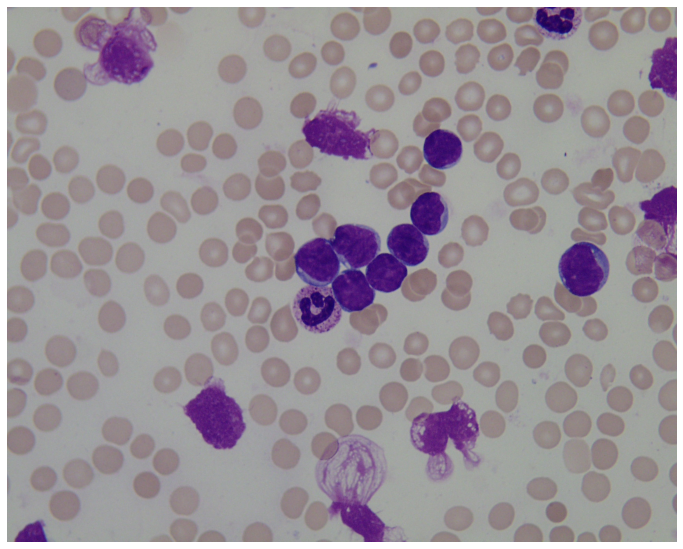

In [165]:
im_test = mpimg.imread("../raw_data/archive/ALL_IDB1/ALL_IDB1/im/im001_1.jpg")

plt.figure(figsize=(12,12))
plt.imshow(im_test)
plt.axis("off")
plt.show();

In [166]:
with open("../raw_data/archive/ALL_IDB1/ALL_IDB1/xyc/im001_1.xyc") as tmp:
    test = tmp.read()

In [167]:
test_clear = test.replace("\t"," ").rstrip()
test_clear

'886 726\n796 653\n894 611\n964 681\n1020 605\n1078 529\n1114 361\n1470 671'

In [168]:
test_list = list(test_clear.split("\n"))
test_list

['886 726',
 '796 653',
 '894 611',
 '964 681',
 '1020 605',
 '1078 529',
 '1114 361',
 '1470 671']

In [169]:
test_list[0].split(" ")

['886', '726']

In [170]:
x = []
y = []
for coor in test_list:
    coords = coor.split(" ")
    x.append(int(coords[0]))
    y.append(int(coords[1]))

In [171]:
x

[886, 796, 894, 964, 1020, 1078, 1114, 1470]

In [172]:
y

[726, 653, 611, 681, 605, 529, 361, 671]

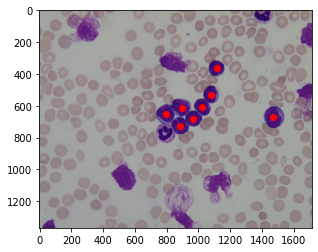

In [173]:
plt.imshow(im_test)
plt.scatter(x, y, color="r")
plt.show();

**Proposed Workflow**

1. Preprocessing

2. Blob detection

3. Image segmentation

4. Leukocyte recognition

5. Leukemia classiﬁcation
---

# 1. Preprocessing

## 1.1 Segmentation with Blob Detection

HSV-Color Space "explained"

![hsv](https://docs.opencv.org/3.4/Threshold_inRange_HSV_colorspace.jpg)

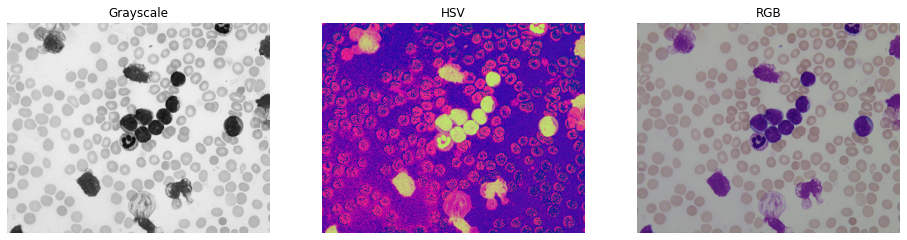

In [174]:
from skimage.color import rgb2hsv
from skimage.color import rgb2gray

im_test_gray = rgb2gray(im_test)
im_test_hsv = rgb2hsv(im_test)

plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(im_test_gray, cmap="gray")
plt.axis("off")
plt.title("Grayscale")
plt.subplot(1,3,2)
plt.imshow(im_test_hsv)
plt.axis("off")
plt.title("HSV")
plt.subplot(1,3,3)
plt.imshow(im_test)
plt.axis("off")
plt.title("RGB");

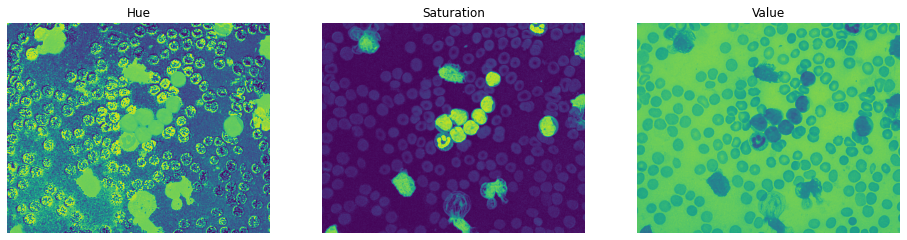

In [175]:
im_test_hue = im_test_hsv[:,:,0]
im_test_sat = im_test_hsv[:,:,1]
im_test_value = im_test_hsv[:,:,2]


plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(im_test_hue)
plt.axis("off")
plt.title("Hue")
plt.subplot(1,3,2)
plt.imshow(im_test_sat)
plt.axis("off")
plt.title("Saturation")
plt.subplot(1,3,3)
plt.imshow(im_test_value)
plt.axis("off")
plt.title("Value");

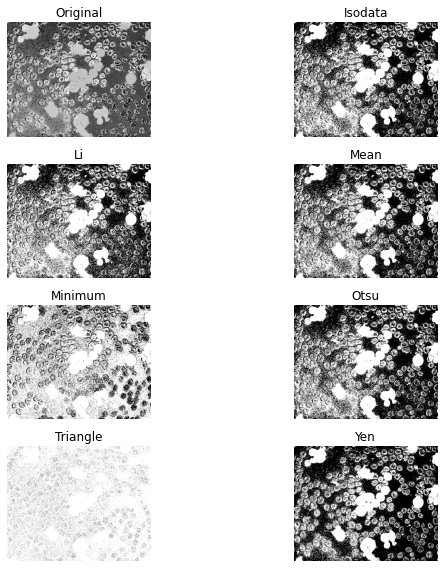

In [176]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(im_test_hue, figsize=(10, 8), verbose=False)
plt.show()

**Trying different Thresholds**

___

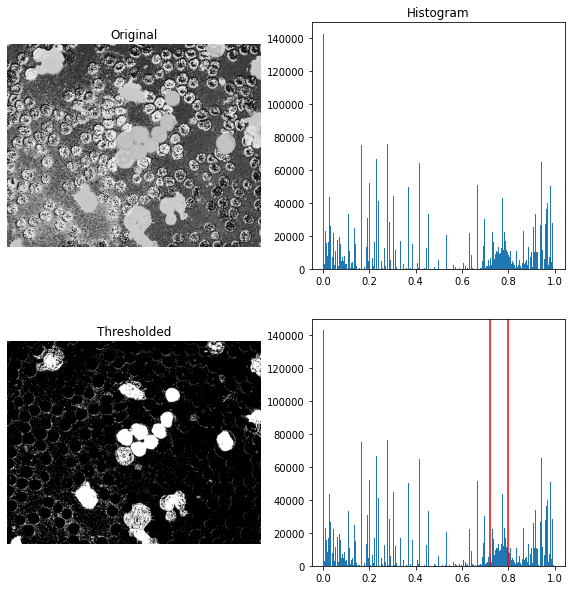

In [177]:
from skimage.filters import threshold_minimum, threshold_otsu, threshold_mean, threshold_isodata, threshold_li, threshold_local
from cv2 import inRange

image = im_test_hue

thresh_min = 0.72 #threshold_mean(image)
thresh_max = 0.8

binary = inRange(image, thresh_min, thresh_max) #thresh_max > image > thresh

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap="gray")

ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary, cmap="gray")
ax[1, 0].set_title('Thresholded')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')
ax[1, 1].axvline(thresh_max, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

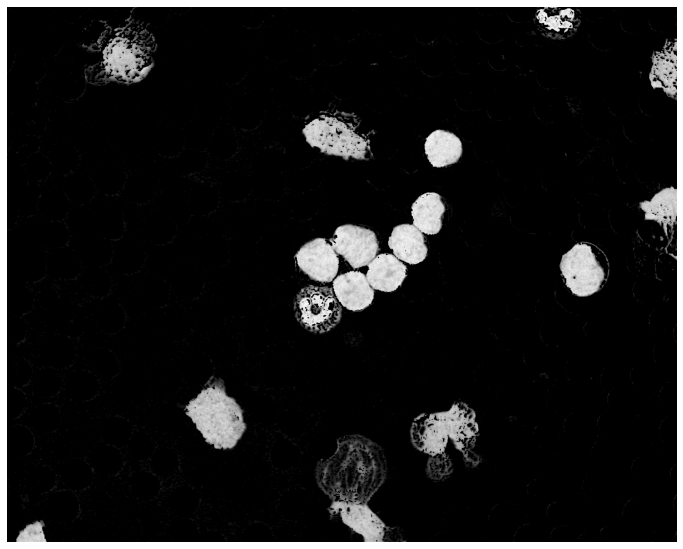

In [178]:
bias = 0.9

im_pre = binary * im_test_sat * bias 

plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(im_pre, cmap="gray");

## 1.1 Blob Detection with skimage

---

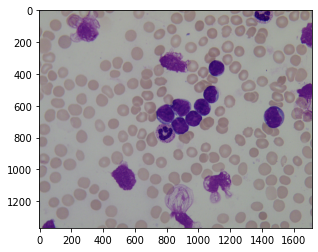

In [179]:
import scipy

im_test_gaus = scipy.ndimage.gaussian_laplace(im_pre, 60)
plt.imshow(im_test, cmap="gray");

In [180]:
im_pre.shape

(1368, 1712)

In [181]:
from skimage.feature import blob_log, blob_doh, blob_dog

min_sigma = 42
max_sigma = 45
num_sigma = 2
threshold = 0.995

blobs_log = blob_log(im_pre, max_sigma= max_sigma, min_sigma = min_sigma, num_sigma=num_sigma, threshold=threshold)
#blobs_dog = blob_dog(im_pre_scaled, max_sigma=40, min_sigma=20, threshold=0.1)
#blobs_doh = blob_doh(im_pre_scaled, max_sigma=40, min_sigma=20, num_sigma=20, threshold=0.1)

blobs_log[:,2] = blobs_log[:,2] * np.sqrt(2)
print(blobs_log.shape)
#print(blobs_dog.shape)
#print(blobs_doh.shape)

(20, 3)


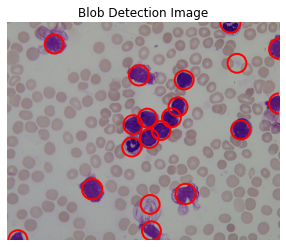

In [182]:
fig, ax = plt.subplots()
ax.imshow(im_test, cmap="gray")
for blob in blobs_log:
    y,x,r = blob
    c = plt.Circle((x, y), r, color="r", linewidth=2, fill=False)
    ax.add_patch(c)

ax.set_axis_off()
ax.set_title("Blob Detection Image");

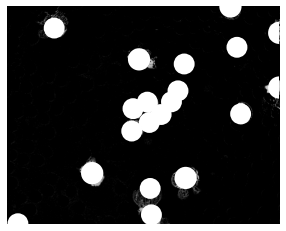

In [183]:
fig, ax = plt.subplots()
ax.imshow(im_pre, cmap="gray")
for blob in blobs_log:
    y,x,r = blob
    c = plt.Circle((x, y), r, color="w", linewidth=2, fill=True)
    ax.add_patch(c)

ax.set_axis_off()

In [184]:
import cv2


"""gray = cv2.cvtColor(im_test,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

sure_bg = cv2.dilate(opening,kernel,iterations=3)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)

markers = markers+1

markers[unknown==255] = 0

markers = cv2.watershed(im_test,markers)
im_test[markers == -1] = [255,0,0]

plt.imshow(markers)
plt.axis("off")"""

#I hate opencv2

'gray = cv2.cvtColor(im_test,cv2.COLOR_BGR2GRAY)\nret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)\n\nkernel = np.ones((3,3),np.uint8)\nopening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)\n\nsure_bg = cv2.dilate(opening,kernel,iterations=3)\n\ndist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)\nret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)\n\nsure_fg = np.uint8(sure_fg)\nunknown = cv2.subtract(sure_bg,sure_fg)\n\nret, markers = cv2.connectedComponents(sure_fg)\n\nmarkers = markers+1\n\nmarkers[unknown==255] = 0\n\nmarkers = cv2.watershed(im_test,markers)\nim_test[markers == -1] = [255,0,0]\n\nplt.imshow(markers)\nplt.axis("off")'

In [185]:
blobs_log[:,2][0]

59.396969619669996

In [186]:
im_test[676,1468]

array([ 62,  11, 114], dtype=uint8)

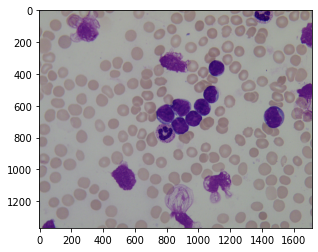

In [187]:
plt.imshow(im_test);

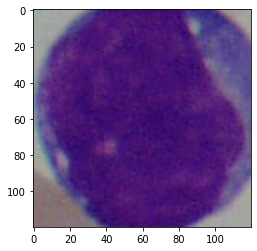

In [188]:
plt.imshow(im_test[676-60:676+60,1468-60:1468+60]);

In [189]:
for blob in blobs_log:
    print(blob)

[ 676.         1468.           59.39696962]
[ 362.         1113.           59.39696962]
[1049.          534.           63.63961031]
[ 510.         1711.           63.63961031]
[ 531.         1074.           59.39696962]
[333.         829.          63.63961031]
[ 166.         1711.           63.63961031]
[136.         295.          59.39696962]
[1367.           67.           59.39696962]
[1079.         1122.           63.63961031]
[643.         791.          59.39696962]
[ 600.         1033.           59.39696962]
[1311.          907.           59.39696962]
[   0.         1404.           63.63961031]
[602.         881.          59.39696962]
[680.         968.          59.39696962]
[730.         894.          59.39696962]
[784.         783.          59.39696962]
[1145.          899.           59.39696962]
[ 257.         1445.           59.39696962]


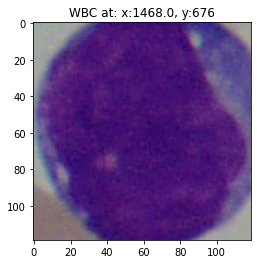

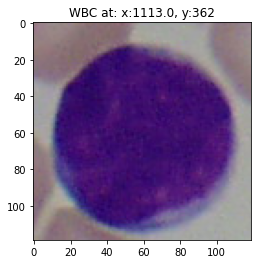

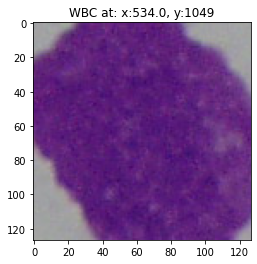

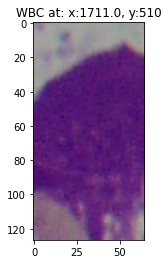

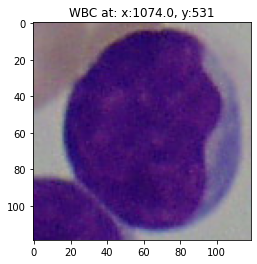

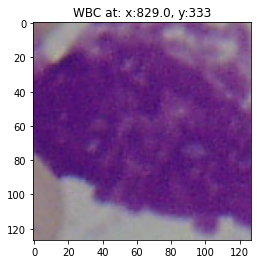

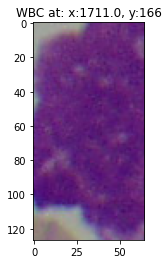

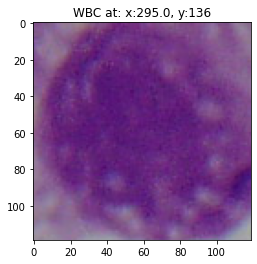

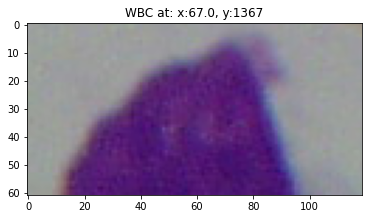

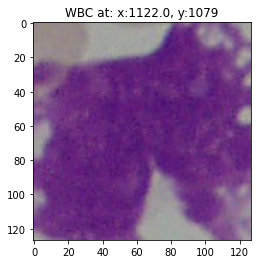

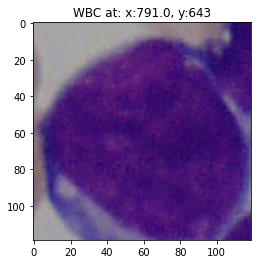

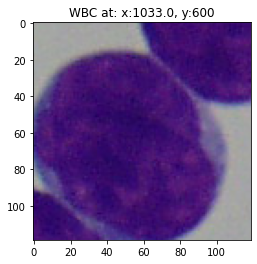

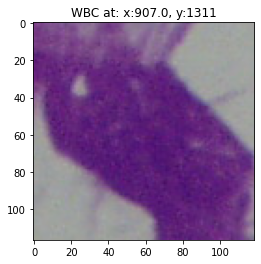

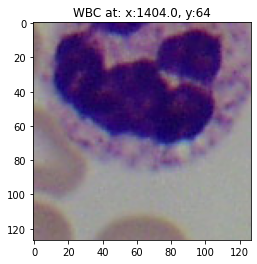

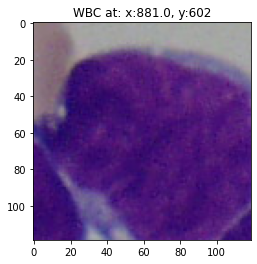

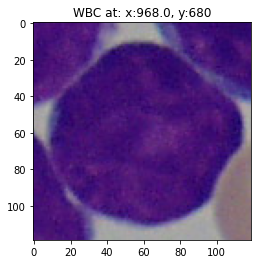

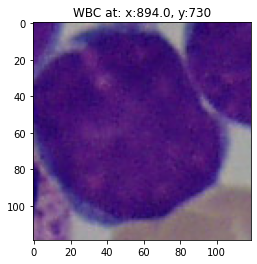

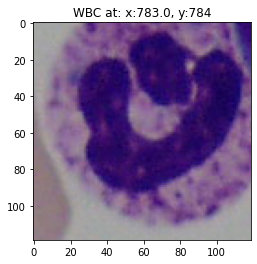

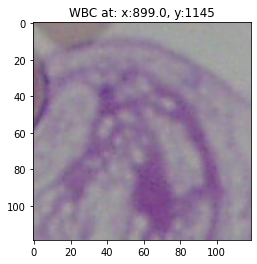

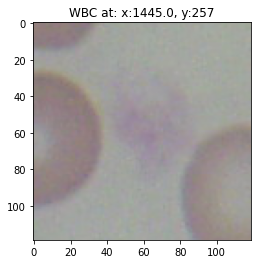

In [190]:
for blob in blobs_log:
    y, x, r = blob
    if y < r:
        y += r
    ROI = im_test[int(y-r):int(y+r),int(x-r):int(x+r)]
    plt.imshow(ROI)
    plt.title(f"WBC at: x:{x}, y:{round(y)}")
    plt.show()

## 1.2 Segmentation with K-means

---

### 1.2.1 Preprocessing

In [209]:
vectorized = im_test.reshape((-1,3))
vectorized = np.float32(vectorized)
vectorized.shape

(2342016, 3)

In [210]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [211]:
k = 4

_, labels, centers = cv2.kmeans(vectorized, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(im_test.shape)

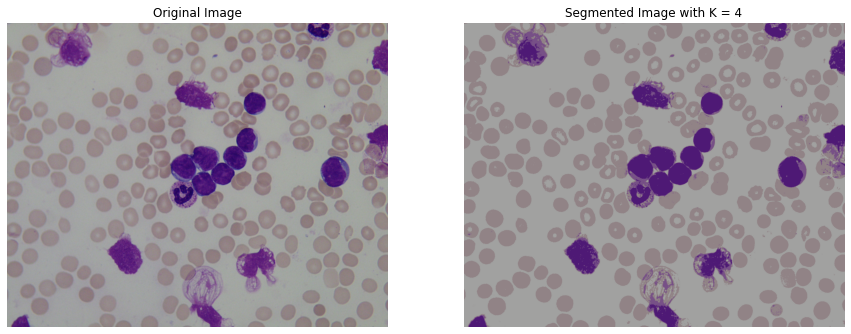

In [212]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1),plt.imshow(im_test)
plt.title('Original Image')
plt.axis("off")
plt.subplot(1,2,2),plt.imshow(segmented_image)
plt.title('Segmented Image with K = %i' % k)
plt.axis("off");

In [213]:
print(np.unique(labels)) # == k 

[0 1 2 3]


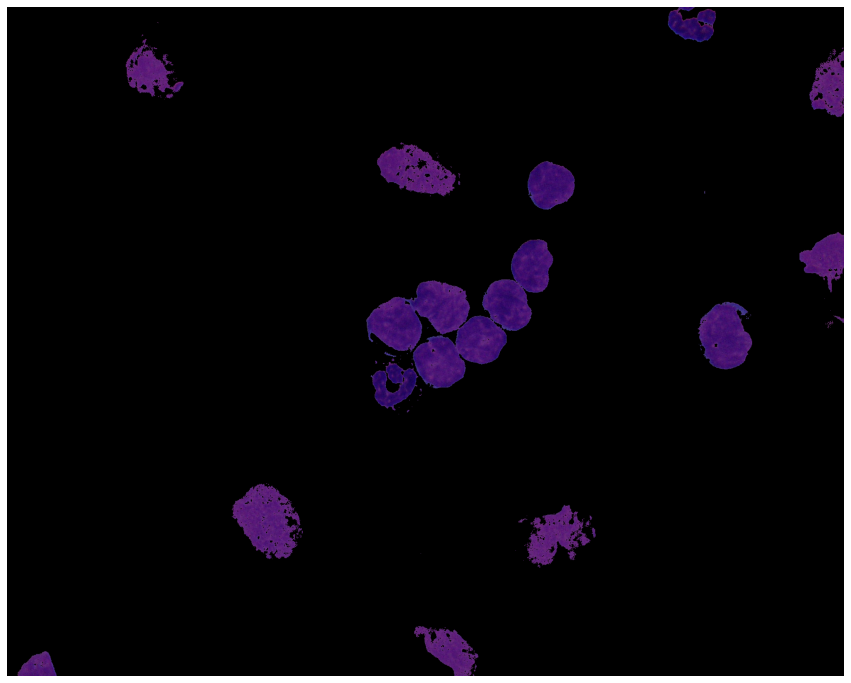

In [224]:
masked_image = np.copy(im_test)

masked_image = masked_image.reshape((-1, 3))

cluster_1 = 2
cluster_2 = 3
cluster_3 = 1

masked_image[labels == cluster_1] = [0, 0, 0]
masked_image[labels == cluster_2] = [0, 0, 0]
masked_image[labels == cluster_3] = [0, 0, 0]

masked_image = masked_image.reshape(im_test.shape)

plt.figure(figsize=(15,15))
plt.imshow(masked_image)
plt.axis("off");

### 1.2.3 Canny Edge Detection

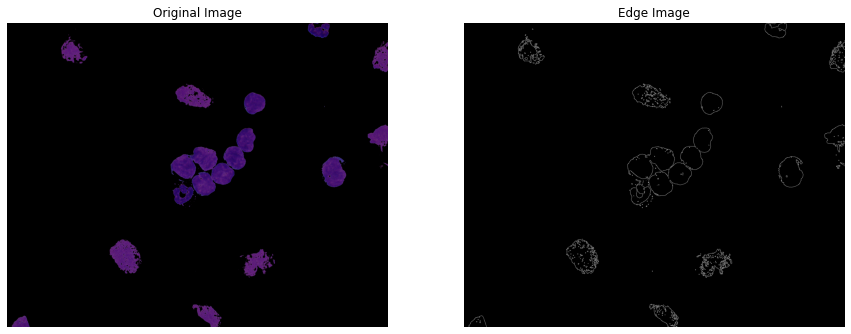

In [225]:
img_in = masked_image

edges = cv2.Canny(img_in,150,200)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img_in)
plt.title('Original Image')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(edges, cmap="gray")
plt.title('Edge Image')
plt.axis("off");

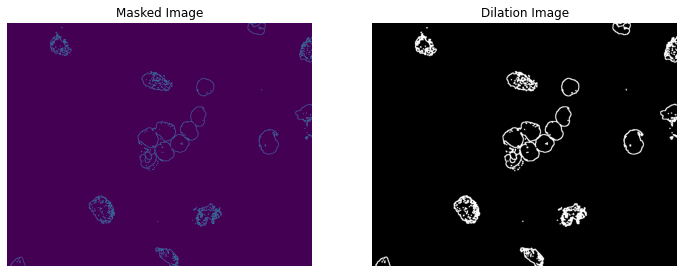

In [226]:
kernel = np.ones((5,5), np.uint8)

img = edges

img_erosion = cv2.erode(img, kernel, iterations=1)
img_dilation = cv2.dilate(img, kernel, iterations=1)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Masked Image')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_dilation, cmap="gray")
plt.title('Dilation Image')
plt.axis("off");

In [227]:
test = img_dilation

h, w = test.shape[:2]

mask = np.zeros((h+2, w+2), np.uint8)

cv2.floodFill(test, mask, (0,0), 255);

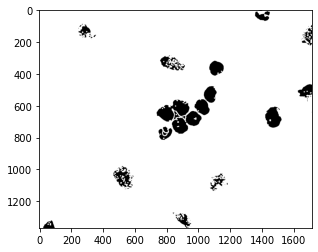

In [228]:
plt.imshow(test, cmap="gray");

In [229]:
im_floodfill_inv = cv2.bitwise_not(test)

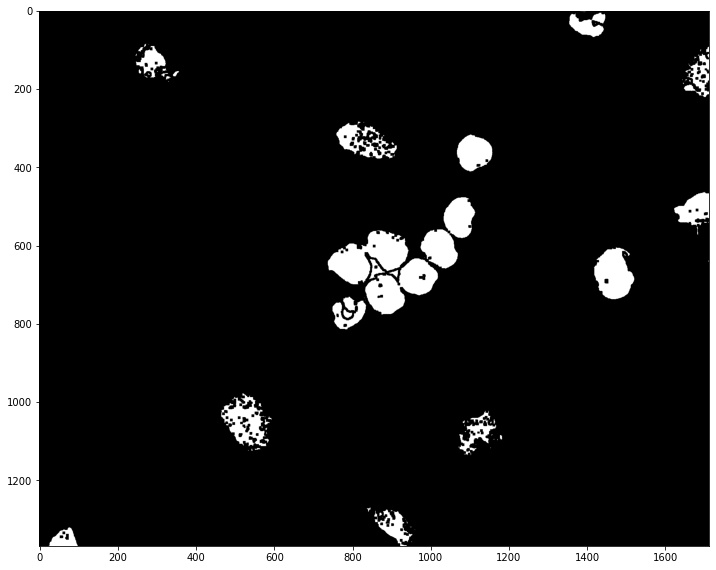

In [230]:
plt.figure(figsize=(12,12))
plt.imshow(im_floodfill_inv, cmap="gray");

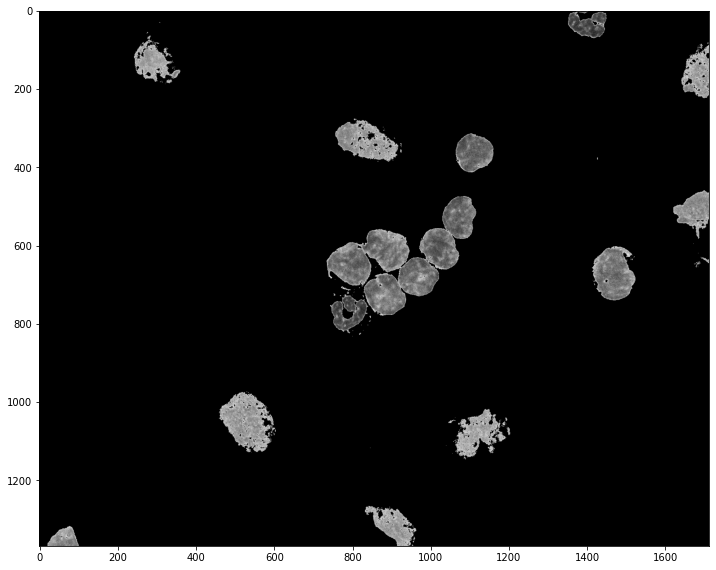

In [237]:
img_in_gray = rgb2gray(img_in)
plt.figure(figsize=(12,12))
plt.imshow(img_in_gray, cmap="gray");